In [14]:
import numpy as np
import h5py
from inverse_MPS import constructInverse
from tensor_networks import MPS, MPStensorProduct
from data_acquisition import generateShadow
from expectation_estimation import shallowEstimation, sparseEstimation

import matplotlib.pyplot as plt


As an example, we will compute the expectation value of $O=|\mathrm{GHZ}\rangle\langle \mathrm{GHZ}|$ and $O=\sum_i Z_{i-1}Z_iZ_{i+1}+X_i$ as in the paper, for $n=8$ qubits and $d=3$. The first is a shallow observable, the second a sparse observable.

In [15]:
n_qubits = 8
depth = 3

First, we create an MPS representation of $\mathcal M_d^{-1}$ for $n=8,d=3$, note that this only had to be done once, subsequently the inverse is stored and can be reused for any state and oservable for $n=8, d=3$. As explained in the paper, at very small values the cost function computation can become inaccurate resulting in negative values.

In [16]:
inverse_bond_dimension = 3
target_accuracy = 1e-15
inverse_file_name = f'data/inverses/M_inverse_n={n_qubits//2}_d={depth}_chi{inverse_bond_dimension}'

constructInverse(n_qubits//2, depth, inverse_bond_dimension,
                 target_accuracy, inverse_file_name, verbose=True, regularize=True)


Distance from inverse: 8.881784197001252e-155

Now we generate a shadow of 1000 snapshots of the GHZ state.

In [17]:
state = MPS(size=n_qubits//2, bond_dimension=2, physical_dimension=4)
for i in range(state.getSize()):
    state.setVector(i, 0, 0, [1/2**(1/n_qubits), 0, 0, 0])
    state.setVector(i, 0, 1, [0, 0, 0, 0])
    state.setVector(i, 1, 0, [0, 0, 0, 0])
    state.setVector(i, 1, 1, [0, 0, 0, 1/2**(1/n_qubits)])

shadow_file_name = f'data/shadows/shadow_n={n_qubits}_d={depth}'
generateShadow(state, depth, 1000, shadow_file_name,
               verbose=True, clifford=False)


Generated 1000 out of 1000 snapshots.

We now use the shadow to get an estimation of the fidelity $\langle\mathrm{GHZ}|\mathrm{GHZ}\rangle$. The input is a vectorization of the observable $O=|\mathrm{GHZ}\rangle\langle \mathrm{GHZ}|$, i.e. $|\mathrm{GHZ}\rangle^{\otimes 2}$.

In [18]:
observable = MPStensorProduct(state, state)

output_file_name = f'data/estimations/GHZ_n={n_qubits//2}_d={depth}'

shallowEstimation(shadow_file_name, inverse_file_name,
                  observable, output_file_name, verbose=True)

estimations_fidelity = h5py.File(output_file_name, 'r')["estimations"][:]


Generated 1000 out of 1000 estimations.

mean:  0.9426548505929334


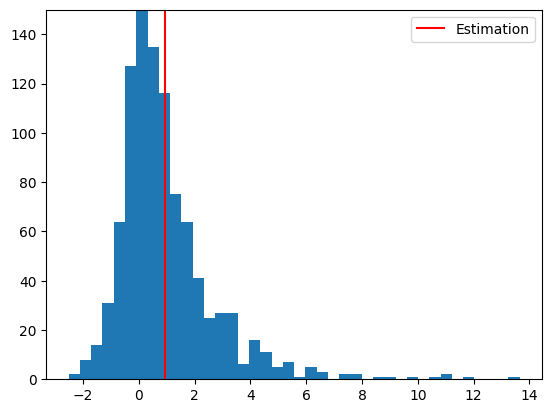

In [19]:
estimated_fidelity = np.real(np.mean(estimations_fidelity))

plt.hist(np.real(estimations_fidelity), 40)
plt.axvline(estimated_fidelity, color='red', label='Estimation')
plt.ylim((0, 150))
plt.legend()
print("mean: ", estimated_fidelity)


Finally, we obtain an estimation of the expectation value of $H$, since this is a sparse observable we do not need the inverse MPS. 

In [20]:
paulis = [[3, 3, 3, 0, 0, 0, 0, 0], [0, 3, 3, 3, 0, 0, 0, 0], [0, 0, 3, 3, 3, 0, 0, 0], [0, 0, 0, 3, 3, 3, 0, 0], [0, 0, 0, 0, 3, 3, 3, 0],
          [0, 0, 0, 0, 0, 3, 3, 3], [3, 0, 0, 0, 0, 0, 3, 3], [3, 3, 0, 0, 0, 0, 0, 3]]+[[int(x == i) for x in range(n_qubits)] for i in range(n_qubits)]

coefficients = [1]*len(paulis)
shadow_file_name = 'data/shadows/shadow_n='+str(n_qubits)+'_d='+str(depth)

output_file_name = 'data/estimations/pauli_n='+str(n_qubits)+'_d='+str(depth)

sparseEstimation(shadow_file_name, depth, paulis,
                 coefficients, output_file_name, verbose=True)

estimations_hamiltonian = h5py.File(output_file_name, 'r')["estimations"][:]


Generated 1000 out of 1000 estimations.

mean:  0.9869999818098155


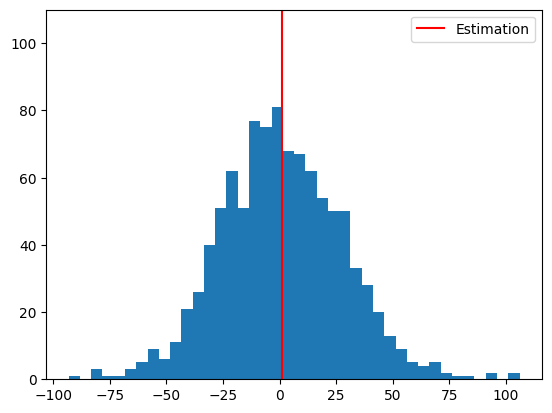

In [21]:
estimated_hamiltonian = np.real(np.mean(estimations_hamiltonian))

plt.hist(np.real(estimations_hamiltonian), 40)
plt.axvline(estimated_hamiltonian, color='red', label='Estimation')
plt.ylim((0, 110))
plt.legend()
print("mean: ", estimated_hamiltonian)
